# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 


##### The goal is to develop a predictive model to analyze and determine the most significant factors influencing used car prices. This involves collecting and preparing relevant datasets, conducting exploratory data analysis to identify potential features, and employing statistical and machine learning techniques to quantify the impact of these features on pricing. Key metrics for model performance will be evaluated to ensure accuracy and reliability in predicting used car prices

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Steps to familiarize with data

1. Read CSV
2. Understand data structure and independent variables
3. Determine missing values and explore the right strategy for treating them (drop columns or rows, and filling missing values - mode or mean)
4. Understand categorical variables
 

In [397]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from  scipy.stats import zscore

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(transform_output="pandas") # get the output in pandas df

from sklearn.impute import SimpleImputer

In [333]:
vehicles = pd.read_csv('data/vehicles.csv')

print("Number of rows and columns in the dataset:")
vehicles.shape

Number of rows and columns in the dataset:


(426880, 18)

In [334]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [335]:
# Pick only the numerical features for describe()
vehicles.select_dtypes(include=['float64', 'int64']).describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Outliers
* Outliers observed in price (min, max), year(min) columns

In [336]:
# unique values per column
vehicles.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [337]:
# Count missing %s
vehicles.isna().mean().round(4)*100

id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [338]:
#Descriptive statistics for categorical variables
vehicles.describe(include=['object', 'category'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


** Categorical values
* Region, Mfr, Model, state have quite few categorical values
* Only 265K unique VIN numbers in a data set of 426K observations

## Data Quality / Clean up

* Irelevant data: remove IDs, VINs

* Remove categorical columns with large number of unique values (region, model, state) - Add them after 1st pass of model creation if needed

* Missing data: remove columns > 50% missing data (size)

* Duplicate data: drop duplicates

* Data Type Conversion
    Extract number of cylinders as numerical value

* Outlier analysis and removal (in price, odometer, and year column)

In [339]:
# remove object columns that we know are not related to the price of a used car such as id, VIN
vehicles_clean = vehicles.drop(columns = ['id', 'VIN'])

# remove categorical variables with very large unique values - region(404), model(29649), state(51)
vehicles_clean = vehicles_clean.drop(columns = ['region', 'model', 'state'])

# remove columns with > 50% missing values
vehicles_clean = vehicles_clean.drop(columns = ['size'])

# drop duplicates
vehicles_clean = vehicles_clean.drop_duplicates()

vehicles_clean.shape

(244870, 12)

In [340]:
# add column for the age of the car
vehicles_clean['age'] = 2024 - vehicles_clean['year']

# drop year column
vehicles_clean = vehicles_clean.drop(columns='year')

In [341]:
# convert cylinders to numeric values
vehicles_clean['cylinders'] = vehicles_clean['cylinders'].str.replace('cylinders', '', regex=False)

vehicles_clean['cylinders_numeric'] = pd.to_numeric(vehicles_clean['cylinders'], errors='coerce', downcast='integer')
print(vehicles_clean['cylinders_numeric'].value_counts())


cylinders_numeric
4.0     56018
6.0     55892
8.0     41499
5.0      1355
10.0      717
3.0       449
12.0      153
Name: count, dtype: int64


In [342]:
# keep prices within IQR

def address_outlier_iqr(df, column):
    iqr = df[column].quantile(.9) - df[column].quantile(.1)
    lower_bound = df[column].quantile(.1) - 1.5 * iqr
    upper_bound = df[column].quantile(.9) + 1.5 * iqr

    df_without_outliers = df[(df[column] > lower_bound) & (df[column] < upper_bound)].copy()
    iqr_data_lost = 1-(df_without_outliers.shape[0]/df.shape[0])
    print("We lost {:.2%} of the data by the IQR method".format(iqr_data_lost), "for the", column, "column")
    
    return df_without_outliers

vehicles_clean = address_outlier_iqr(vehicles_clean, 'price')
vehicles_clean = address_outlier_iqr(vehicles_clean, 'odometer')

vehicles_clean.select_dtypes(include=['float64', 'int64']).describe()



We lost 0.45% of the data by the IQR method for the price column
We lost 1.48% of the data by the IQR method for the odometer column


,price,odometer,age,cylinders_numeric
count,240175.000000,240175.000000,239562.000000,154037.000000
mean,14011.897142,103244.369385,14.574578,5.810578
std,12854.170825,64096.450892,10.628936,1.611399
min,0.000000,0.000000,2.000000,3.000000
25%,4950.000000,52396.000000,8.000000,4.000000
50%,9999.000000,99761.000000,12.000000,6.000000
75%,19748.000000,145000.000000,18.000000,8.000000
max,78609.000000,440000.000000,124.000000,12.000000


In [332]:
# ZScore method

#vehicles_clean[np.abs(zscore(vehicles_clean['price'])) < 3]['price']
#

In [343]:
vehicles_clean.isna().mean().round(4)*100

price                 0.00
manufacturer          4.12
condition            39.40
cylinders            35.46
fuel                  0.56
odometer              0.00
title_status          1.60
transmission          0.39
drive                28.23
type                 25.01
paint_color          29.66
age                   0.26
cylinders_numeric    35.86
dtype: float64

## Exploratory Data Analysis (EDA)

* Univariate

* Bi-variate (price as the main focus)
    For ex: how cylinders and prices move together


#### Numerical Variables

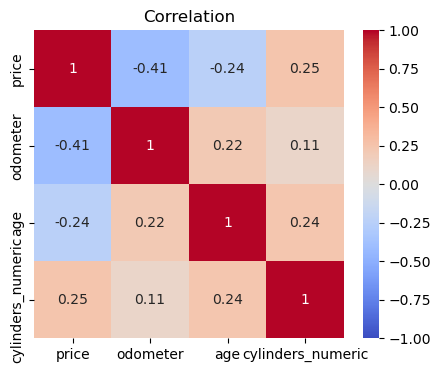

In [352]:
# Create a correlation heatmap using numerical features

plt.figure(figsize=(5, 4))
sns.heatmap(vehicles_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation')
plt.show()

# Half Heatmap
    # corr = df_numeric.corr(numeric_only = True)
    # mask = np.triu(np.ones_like(corr.round(2)))
    # sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu");

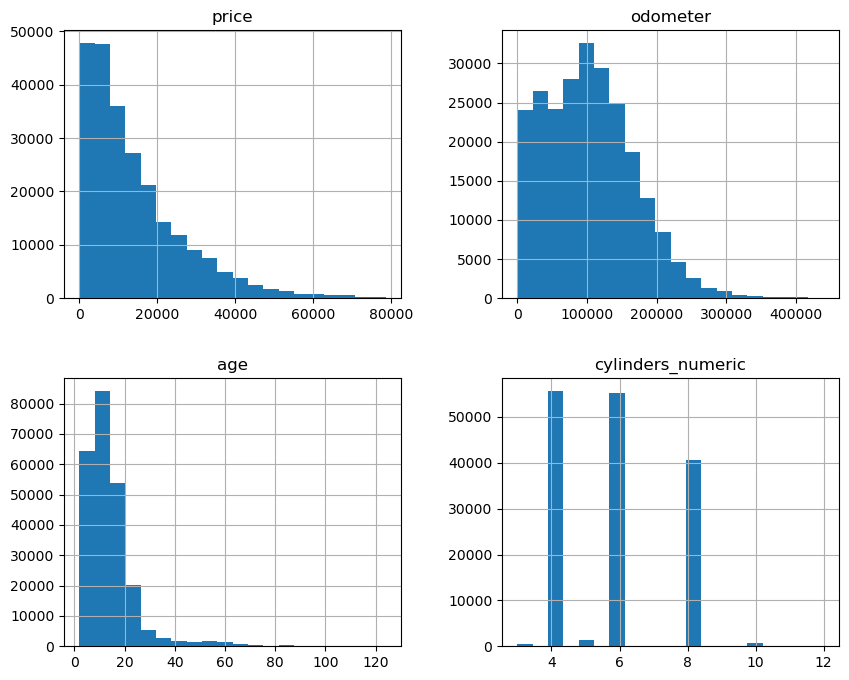

In [353]:
# Histogram/Barplots for numerical variables
vehicles_clean.hist(bins=20, figsize=(10, 8))
plt.show()

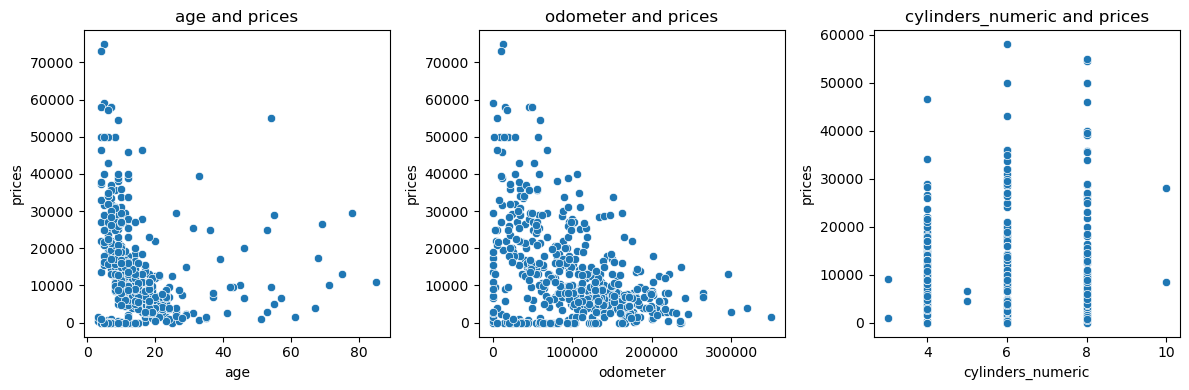

In [381]:
# Pick a random sample for displaying and diserning any patterns in scatter plots
np.random.seed(42)
df_numeric_sample = vehicles_clean.sample(500)

# Numerical variables
numerical_columns = ['age', 'odometer', 'cylinders_numeric']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(numerical_columns):
    sns.scatterplot(x=df_numeric_sample[column], y=df_numeric_sample['price'], ax=axes[i])
    axes[i].set_title(f'{column} and prices')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('prices')

plt.tight_layout()
plt.show()

* It appears that as age and odometer of the car increases the price goes down
* Cars with 6-8 cylinders appear to get more price

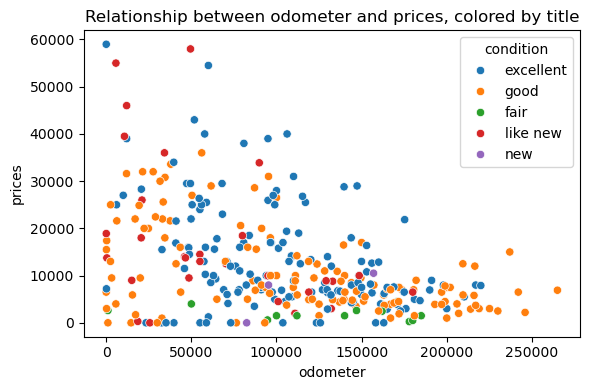

In [379]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_numeric_sample['odometer'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

plt.title('Relationship between odometer and prices, colored by title')
plt.xlabel('odometer')
plt.ylabel('prices')

plt.tight_layout()
plt.show()

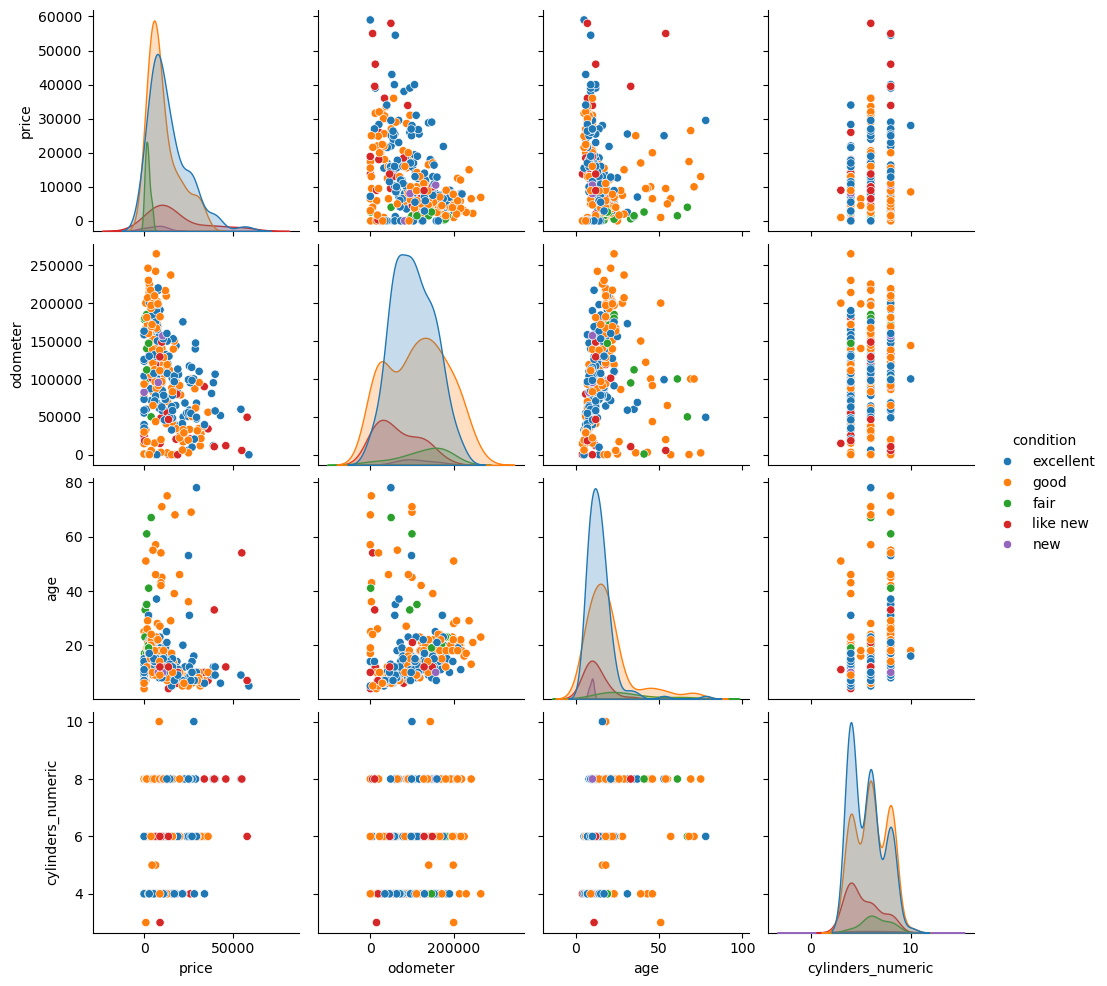

In [378]:
sns.pairplot(df_numeric_sample , hue='condition' )

#### Categorical Variables

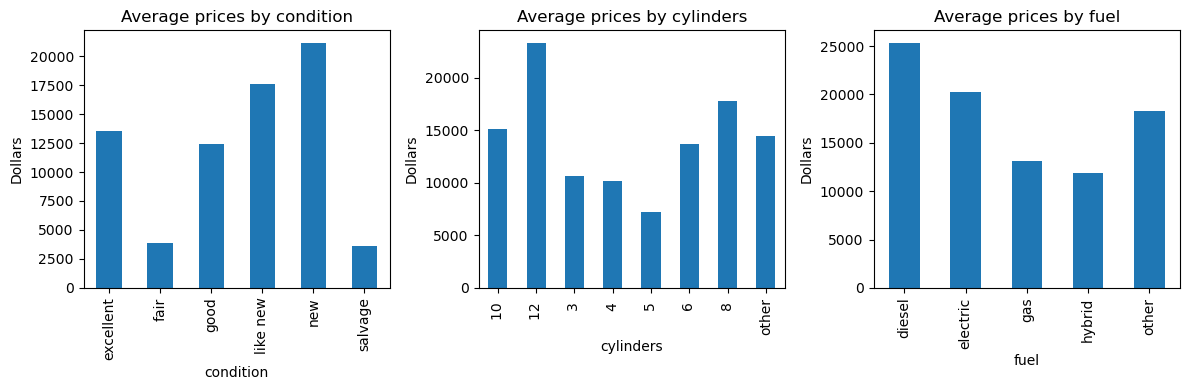

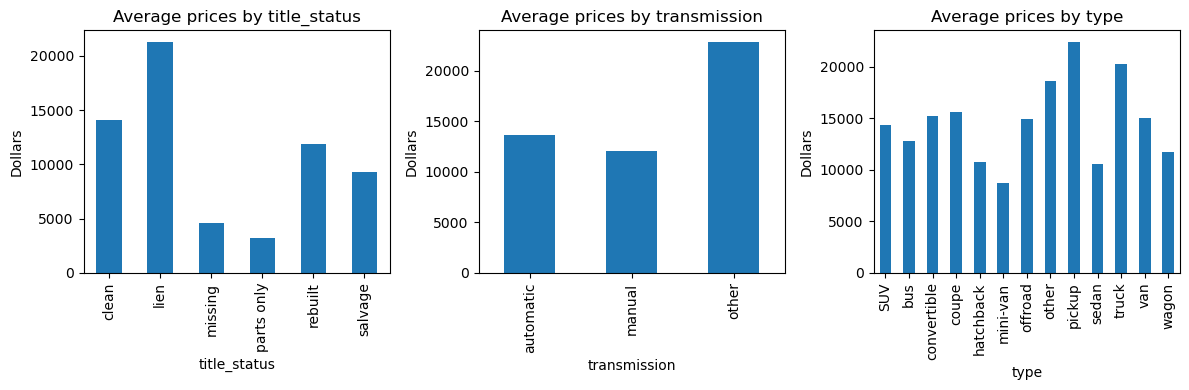

In [364]:
# Let's explore the price cost by categorical variables
categorical_columns = ['condition', 'cylinders', 'fuel']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Dollars')

plt.tight_layout()
plt.show()

categorical_columns = ['title_status', 'transmission', 'type']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Dollars')

plt.tight_layout()
plt.show()



##### Interpretation

* Cars with condition (New/Like New) tend to be priced higher. On the other hands cars with salvaged condition tend to be priced the lowest
* Pickups tend to attract higher prices, mini-vans on the other hand appear to sell for less
* Diesel vehicles tend to attract higher prices
* Cars with more cyclinders are more expensive


## Pre-processing

Standardization and Scaling

## Feature Engineered

## Modeling

* LR
* RR
* Lasso

# Data set combination

* Step 1: Numerical Only
* Step 2: Numerical + Simple Categorical (OHE)
* Step 3: Step 2 + Non Trivial - Orinal Encoding

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.